In [31]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

torch.set_printoptions(edgeitems=2)

In [32]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [33]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 9,  6,  1,  8, 10,  7,  5,  0,  3]), tensor([2, 4]))

In [34]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val
t_un_val

tensor([[5.8200],
        [5.6300]])

In [35]:
seq_model = nn.Sequential(nn.Linear(1, 13), nn.Tanh(), nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [36]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [45]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1,8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [43]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.2983], requires_grad=True)

In [44]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_un_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_un_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch {}, Training Loss {}, Validation Loss {}'.format(epoch, float(loss_train), float(loss_val)))

In [46]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_u_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training Loss 201.0591583251953, Validation Loss 186.11660766601562
Epoch 1000, Training Loss 4.904975414276123, Validation Loss 2.461806535720825
Epoch 2000, Training Loss 2.2061080932617188, Validation Loss 1.8469972610473633
Epoch 3000, Training Loss 1.859580159187317, Validation Loss 1.8492025136947632
Epoch 4000, Training Loss 1.7916698455810547, Validation Loss 1.9210689067840576
Epoch 5000, Training Loss 1.7744094133377075, Validation Loss 1.968665361404419
output tensor([[13.2844],
        [11.9970]], grad_fn=<AddmmBackward>)
answer tensor([[15.],
        [11.]])
hidden tensor([[ 0.0013],
        [-0.0056],
        [-0.0042],
        [ 0.0204],
        [ 0.0022],
        [-0.0007],
        [ 0.0057],
        [ 0.0042]])


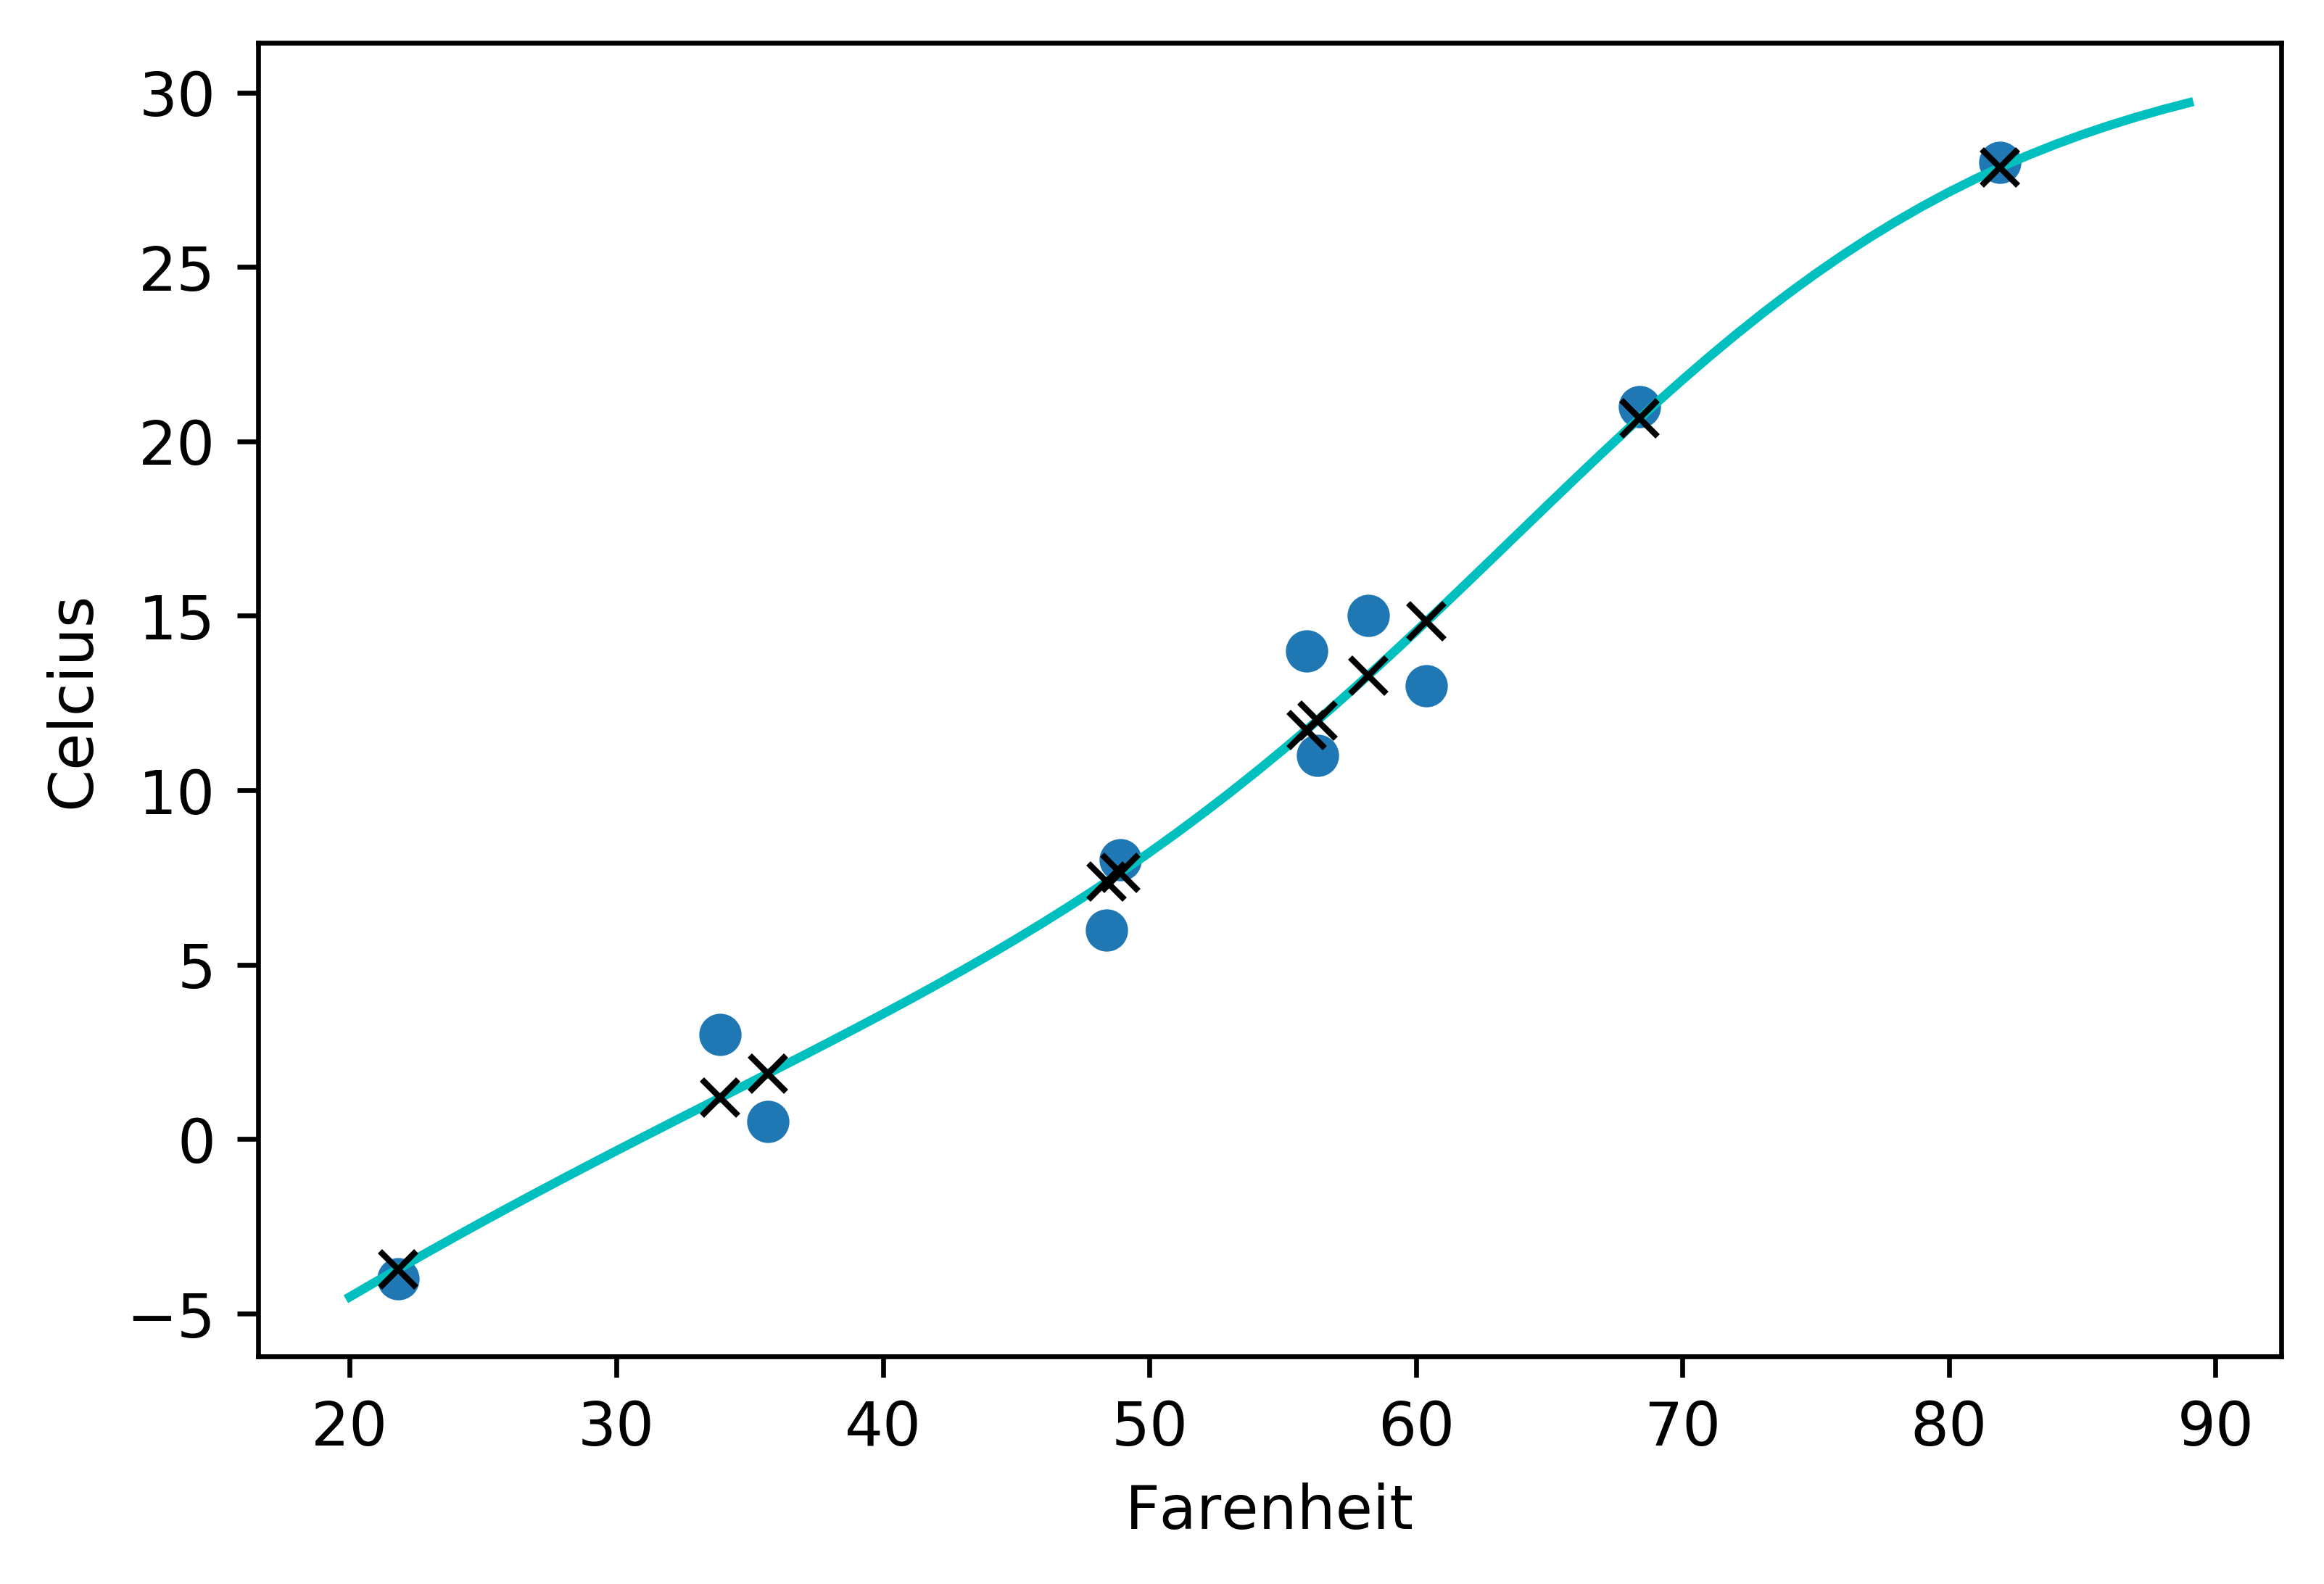

In [47]:
import matplotlib.pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel('Farenheit')
plt.ylabel('Celcius')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [24]:
class SubclassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 13)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(13, 1)
        
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = self.hidden_activation(hidden_t)
        output_t = self.output_linear(activated_t)
        
        return output_t

subclass_model = SubclassModel()
subclass_model
 

SubclassModel(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)